### Обработка данных

In [14]:
import pandas as pd
import numpy as np
%config Completer.use_jedi = False
import sqlite3 

**Загружаем csv в базу данных**

In [16]:
con_submission = sqlite3.connect('submission.db')
submission=pd.read_csv("submission_data_test.csv")
events=pd.read_csv("events_data_test.csv")
submission.to_sql("submission", con_submission, if_exists='append', index=False)
events.to_sql("events",con_submission, if_exists='append', index=False)
cur_sub = con_submission.cursor()

**Создаем таблицу с столбцам : имя студента, количество очков, набрал 40 баллов или нет** 

In [137]:
select=[]
for row in cur_sub.execute("SELECT user_id,count(*), CASE \
                                                     WHEN count(*)<40 THEN 0 \
                                                     ELSE 1 \
                                                     END \
                            FROM submission \
                            WHERE submission_status=:correct \
                            GROUP BY user_id",{"correct":"correct"}):
    select.append(row)
Student_with_score=pd.DataFrame(select,columns=["user_id","score","success"])
Student_with_score

,user_id,score,success
0,12,9,0
1,13,261,1
2,15,90,1
3,21,216,1
4,35,63,1
...,...,...,...
2758,26775,414,1
2759,26780,144,1
2760,26785,27,0
2761,26796,18,0


**Создаем таблицу с столбацми : имя студента, действия и количетсво этих действий**

In [21]:
select=[]
for row in cur_sub.execute("SELECT user_id, action,count(*) \
                            FROM events \
                            GROUP BY 1,2"):
    select.append(row)
Student_with_action=pd.DataFrame(select,columns=["user_id","action","count_each_action"])    
Student_with_action

,user_id,action,count_each_action
0,4,discovered,7
1,4,passed,7
2,4,viewed,7
3,6,discovered,7
4,6,passed,7
...,...,...,...
21330,26799,started_attempt,14
21331,26799,viewed,42
21332,26800,discovered,7
21333,26800,started_attempt,7


**Сделаем более удобное представление данных**

In [25]:
Action=Student_with_action.pivot(index="user_id",columns="action",values="count_each_action")
Action=Action.fillna(0).reset_index()
Action

action,user_id,discovered,passed,started_attempt,viewed
0,4,7.0,7.0,0.0,7.0
1,6,7.0,7.0,0.0,7.0
2,10,14.0,14.0,0.0,42.0
3,12,77.0,63.0,28.0,98.0
4,13,490.0,490.0,245.0,735.0
...,...,...,...,...,...
6179,26791,7.0,7.0,0.0,7.0
6180,26795,7.0,7.0,0.0,7.0
6181,26796,42.0,28.0,14.0,84.0
6182,26799,42.0,42.0,14.0,42.0


**Создали таблицу, куда записали кол-во неправильных ответов**

In [141]:
 
wrong=submission[submission.submission_status=="wrong"].groupby(["user_id"]).agg({"step_id":"count"}).\
reset_index().rename(columns={'step_id': 'wrong'})

**Найдем среднее время между прохождением степов для каждого ученика**

In [136]:
 
select=[]
for row in cur_sub.execute("SELECT user_id, ROUND(AVG(time_diff)/60,1) FROM(SELECT user_id, -LAG (timestamp) OVER ( PARTITION BY user_id ORDER BY timestamp) \
                                                                +timestamp AS time_diff \
                            FROM submission \
                            WHERE submission_status=:correct) \
                            GROUP BY 1 \
                            ",{"correct":"correct"}):
    select.append(row)
time_diff=pd.DataFrame(select,columns=["user_id","mean_diff_min"])    
time_diff

,user_id,mean_diff_min
0,12,0.0
1,13,8.2
2,15,18.1
3,21,0.4
4,35,2.9
...,...,...
2758,26775,5.6
2759,26780,12.0
2760,26785,2.6
2761,26796,0.2


In [145]:
First_merge=pd.merge(time_diff,Student_with_score,"inner",on="user_id")
Second_merge=pd.merge(First_merge,Action,how="right",on="user_id").fillna(0)
Second_merge

,user_id,mean_diff_min,score,success,discovered,passed,started_attempt,viewed
0,4,0.0,0.0,0.0,7.0,7.0,0.0,7.0
1,6,0.0,0.0,0.0,7.0,7.0,0.0,7.0
2,10,0.0,0.0,0.0,14.0,14.0,0.0,42.0
3,12,0.0,9.0,0.0,77.0,63.0,28.0,98.0
4,13,8.2,261.0,1.0,490.0,490.0,245.0,735.0
...,...,...,...,...,...,...,...,...
6179,26791,0.0,0.0,0.0,7.0,7.0,0.0,7.0
6180,26795,0.0,0.0,0.0,7.0,7.0,0.0,7.0
6181,26796,0.2,18.0,0.0,42.0,28.0,14.0,84.0
6182,26799,0.1,18.0,0.0,42.0,42.0,14.0,42.0


<AxesSubplot:>

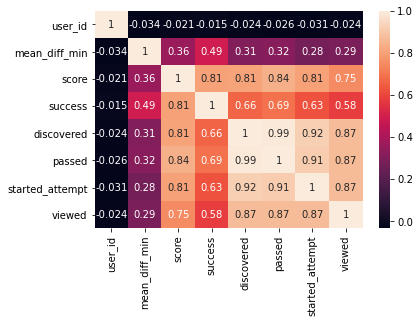

In [194]:
#Все переменные несут смысл
import seaborn as sns
sns.heatmap(Second_merge.corr(), annot=True)

### Обучение модели, используя Random Forest

In [150]:
x=Second_merge.drop("success",axis=1)
y=Second_merge.success   

In [159]:
from sklearn import tree
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import train_test_split

**Разбиваем данные на test и trian. Указываем диапазоны для параметров RandomForest**

In [214]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)
parametrs={"n_estimators":[i*5 for i in range(2,100)],\
           'max_depth':range(1,100,2), 'min_samples_leaf':range(1,20,2),\
           'min_samples_split':range(1,20,2)}
clf=RandomForestClassifier()
search = RandomizedSearchCV(clf,parametrs,n_jobs=-1,cv=5)

**Находим лучшие параметры для RandomForest**

In [215]:
search.fit(X_train,y_train)
search.best_params_

C:\Users\bubul\miniconda3\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [ 1.  1.  1.  1.  1.  1.  1.  1.  1. nan]
  warnings.warn(


{'n_estimators': 225,
 'min_samples_split': 3,
 'min_samples_leaf': 1,
 'max_depth': 69}

In [216]:
best_clf=search.best_estimator_

**Находим значения для новых данных**

In [221]:
sub_test=pd.read_csv("https://stepik.org/media/attachments/course/4852/submission_data_test.csv")
events_test=pd.read_csv("https://stepik.org/media/attachments/course/4852/events_data_test.csv")
sub_test.to_sql("submission_test", con_submission, if_exists='append', index=False)
events_test.to_sql("events_test",con_submission, if_exists='append', index=False)



In [222]:
select=[]
for row in cur_sub.execute("SELECT user_id, action,count(*) \
                            FROM events_test \
                            GROUP BY 1,2"):
    select.append(row)
Student_with_action=pd.DataFrame(select,columns=["user_id","action","count_each_action"])    
Action=Student_with_action.pivot(index="user_id",columns="action",values="count_each_action")
Action=Action.fillna(0).reset_index()
select=[]
for row in cur_sub.execute("SELECT user_id, ROUND(AVG(time_diff)/60,1) FROM(SELECT user_id, -LAG (timestamp) OVER ( PARTITION BY user_id ORDER BY timestamp) \
                                                                +timestamp AS time_diff \
                            FROM submission_test \
                            WHERE submission_status=:correct) \
                            GROUP BY 1 \
                            ",{"correct":"correct"}):
    select.append(row)
time_diff=pd.DataFrame(select,columns=["user_id","mean_diff_min"])    
select=[]
for row in cur_sub.execute("SELECT user_id,count(*)\
                            FROM submission_test \
                            WHERE submission_status=:correct \
                            GROUP BY user_id",{"correct":"correct"}):
    select.append(row)
Student_with_score=pd.DataFrame(select,columns=["user_id","score"])
First_merge=pd.merge(time_diff,Student_with_score,"inner",on="user_id")
Second_merge=pd.merge(First_merge,Action,how="right",on="user_id").fillna(0)
x_test=Second_merge

In [223]:
prob_pred=best_clf.predict_proba(x_test)[:,1]


In [224]:
resalt=pd.DataFrame()
resalt["user_id"]=Second_merge["user_id"]
resalt["is_gone"]=prob_pred
resalt.to_csv("resalt.csv")

**Финальный roc_auc  =  0.83014**

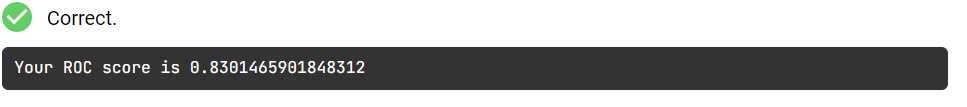